# Calculate distance from Startups to Company A

In [203]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

In [204]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
df = pd.read_excel(r"C:\Users\Admin\Documents\Studio Code\startup_partnerships\Germany Startups Dataset.xlsx", sheet_name='Encoded')
df

,No.,Company,Industry,AdTech,Cybersecurity,Digital Health,Digital Chemistry,E-Commerce,Education,FinTech,...,num_headquart,dist_bin,dist_bin_no,Startup founders,num_of_founder,num_of_female,percent_female,Website,Email,high_potential
0,1,1A Robotics,Cross-industry,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,Very Close,1,Manquel Tejeda Neira,1,0,0.0,http://www.1arobotics.com,manquel(at)(one)arobotics.com,0
1,2,2VizCon,"MediaTech, Education, E-Commerce",0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,Very Close,1,"Walter Scheuer, Oliver Turnbull, Wryland Reed",3,0,0.0,https://2viz.io,walter(at)(two)viz.io,0
2,3,3dvisionlabs GmbH,Smart Systems,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,Far,4,"Dr. Michel Findeisen, Lars Meinel, Markus Hess",3,0,0.0,https://3dvisionlabs.com/,info(at)(three)dvisionlabs.com,0
3,4,4mobil,SaaS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,Commutable,3,Sakir Kürt,1,0,0.0,https://4mobil.de/,sk(at)werkelf.com,0
4,5,Acalta GmbH,"Digital Health, SaaS",0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,Commutable,3,"Frederik Kaul, Nico Ploner, Simon Winkler",3,0,0.0,https://www.acalta.de/,info(at)acalta(dot)de,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,751,Zesavi,"MediaTech, Education, SaaS, Cross-Industry",0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,Far,4,"Maximilian Zeyda, Edwin Sauer",2,0,0.0,https://zesavi.com,founder(at)zesavi(dot)com,0
751,752,ZF Car eWallet GmbH,"Logistics, FinTech, Mobility, Smart Systems, S...",0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1,Far,4,Thorsten Weber + ZF Friedrichshafen AG,2,0,0.0,http://www.car-ewallet.de,thorsten(dot)weber(at)car-ewallet(dot)de,0
752,753,zkSystems,"SaaS, Smart Systems, Smart Infrastructure",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,Far,4,"Diana Rees, CEO, Amine Ünal, CTO",2,1,50.0,http://zksystems.io,info(at)zksystems.io,0
753,754,Zolitron Technology,"Logistics, SaaS",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,Commutable,3,Arndt-Hendrik Zinn,1,0,0.0,https://zolitron.com/,info(at)zolitron(dot)com,1


In [205]:
#distance to company A
compA = (50.1235823,8.5727836)
df['dist_A'] = df.apply(lambda row: geodesic((row['Latitude'], row['Longitude']), compA).kilometers, axis=1)
df['dist_A']

0        7.949222
1       11.129188
2      318.361436
3      167.303757
4      184.615765
          ...    
750    305.784653
751    428.508754
752    428.508754
753    178.678863
754     95.273893
Name: dist_A, Length: 755, dtype: float64

In [ ]:
df.to_excel('distance.xlsx', index=False)

# Correlation

In [206]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

In [208]:
df = pd.read_excel(r"C:\Users\Admin\Documents\Studio Code\startup_partnerships\data2_after_imputed.xlsx")
df

,AdTech,Cybersecurity,Digital Health,Digital Chemistry,E-Commerce,Education,FinTech,InsurTech,LegalTech,Logistics,...,size_no,funding_no,market_no,num_headquart,dist_A,dist_bin_no,num_of_founder,num_of_female,percent_female,high_potential
0,0,0,0,0,0,0,0,0,0,0,...,1,3,3,1,7.949222,1,1,0,0,0
1,0,0,0,0,1,1,0,0,0,0,...,2,3,3,1,11.129188,1,3,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,3,2,1,318.361436,4,3,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,2,1,1,167.303757,3,1,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,1,1,1,1,184.615765,3,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,0,0,0,0,0,1,0,0,0,0,...,1,1,4,1,305.784653,4,2,0,0,0
751,0,0,0,0,0,0,1,0,0,1,...,2,4,4,1,428.508754,4,2,0,0,0
752,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,428.508754,4,2,1,50,0
753,0,0,0,0,0,0,0,0,0,1,...,1,1,3,1,178.678863,3,1,0,0,1


In [209]:
cate_col = df[['AdTech',
'Cybersecurity',
'Digital Health',
'Digital Chemistry',
'E-Commerce',
'Education',
'FinTech',
'InsurTech',
'LegalTech',
'Logistics',
'MediaTech',
'Mobility',
'SaaS',
'Smart Infrastructure',
'Smart Systems',
'Cross-industry',
'Artificial intelligence',
'Blockchain',
'Robotics',
'Virtual Reality',
'Hardware',
'Software Development',
'Data Analytics',
'Internet of Things',
'Partner',
'Financing',
'Talents',
'Mentoring',
'funding_no',
'Hub Berlin',
'Hub Cologne',
'Hub Dresden/Leipzig',
'Hub Dortmund',
'Hub Frankfurt/Darmstadt',
'Hub Hamburg',
'Hub Karlsruhe',
'Hub Mannheim/Ludwigshafen',
'Hub Munich',
'Hub Potsdam',
'Hub Nuremberg/Erlangen',
'Hub Stuttgart',
'Not part of the network yet',
'size_no',
'market_no',
'b2b',
'b2c',
'num_headquart',
'dist_bin_no',
'num_of_founder',
'num_of_female',
'percent_female',
'high_potential'
]]

In [210]:
# Calculate the matrix of contingency coefficients
num_vars = cate_col.shape[1]

def cramers_v(var1, var2):
    #contingency table 
    crosstab = pd.crosstab(var1, var2, dropna=False)

    # chi-squared
    chi2, _, _, _ = chi2_contingency(crosstab)

    #Total observations
    n = crosstab.to_numpy().sum()
    min_dim = min(crosstab.shape) - 1

    # Cramer's v
    if min_dim == 0 or n == 0:
        return np.nan  # Avoid division by zero if the table is empty or has 1 category
    else:
        return np.sqrt(chi2 / (n * min_dim))

In [211]:
rows = []
for col1 in cate_col.columns:
    col = []
    for col2 in cate_col.columns:
        cramers = cramers_v(cate_col[col1], cate_col[col2])
        col.append(round(cramers, 2))
    rows.append(col)

cramers_results = pd.DataFrame(rows, columns=cate_col.columns, index=cate_col.columns)
cramers_results

df1=pd.DataFrame(cramers_results,columns=cate_col.columns,index=cate_col.columns)


In [212]:
selected_vars = ['percent_female', 'Hub Karlsruhe', 'Internet of Things',
                 'funding_no', 'Artificial intelligence', 'Smart Systems',
                 'b2c', 'Data Analytics', 'dist_bin_no', 'high_potential']

# Filter the Cramér's V results to only include the specified variables
filtered_cramers_results = cramers_results.loc[selected_vars, selected_vars]

# Display the filtered DataFrame
filtered_cramers_results

,percent_female,Hub Karlsruhe,Internet of Things,funding_no,Artificial intelligence,Smart Systems,b2c,Data Analytics,dist_bin_no,high_potential
percent_female,1.00,0.05,0.07,0.09,0.07,0.08,0.11,0.06,0.09,0.06
Hub Karlsruhe,0.05,0.99,0.06,0.08,0.13,0.16,0.06,0.03,0.29,0.20
Internet of Things,0.07,0.06,1.00,0.14,0.07,0.50,0.10,0.12,0.13,0.20
funding_no,0.09,0.08,0.14,1.00,0.07,0.13,0.17,0.15,0.14,0.27
Artificial intelligence,0.07,0.13,0.07,0.07,1.00,0.09,0.10,0.35,0.13,0.18
Smart Systems,0.08,0.16,0.50,0.13,0.09,1.00,0.10,0.06,0.13,0.14
b2c,0.11,0.06,0.10,0.17,0.10,0.10,1.00,0.07,0.02,0.11
Data Analytics,0.06,0.03,0.12,0.15,0.35,0.06,0.07,1.00,0.14,0.12
dist_bin_no,0.09,0.29,0.13,0.14,0.13,0.13,0.02,0.14,1.00,0.26
high_potential,0.06,0.20,0.20,0.27,0.18,0.14,0.11,0.12,0.26,0.99


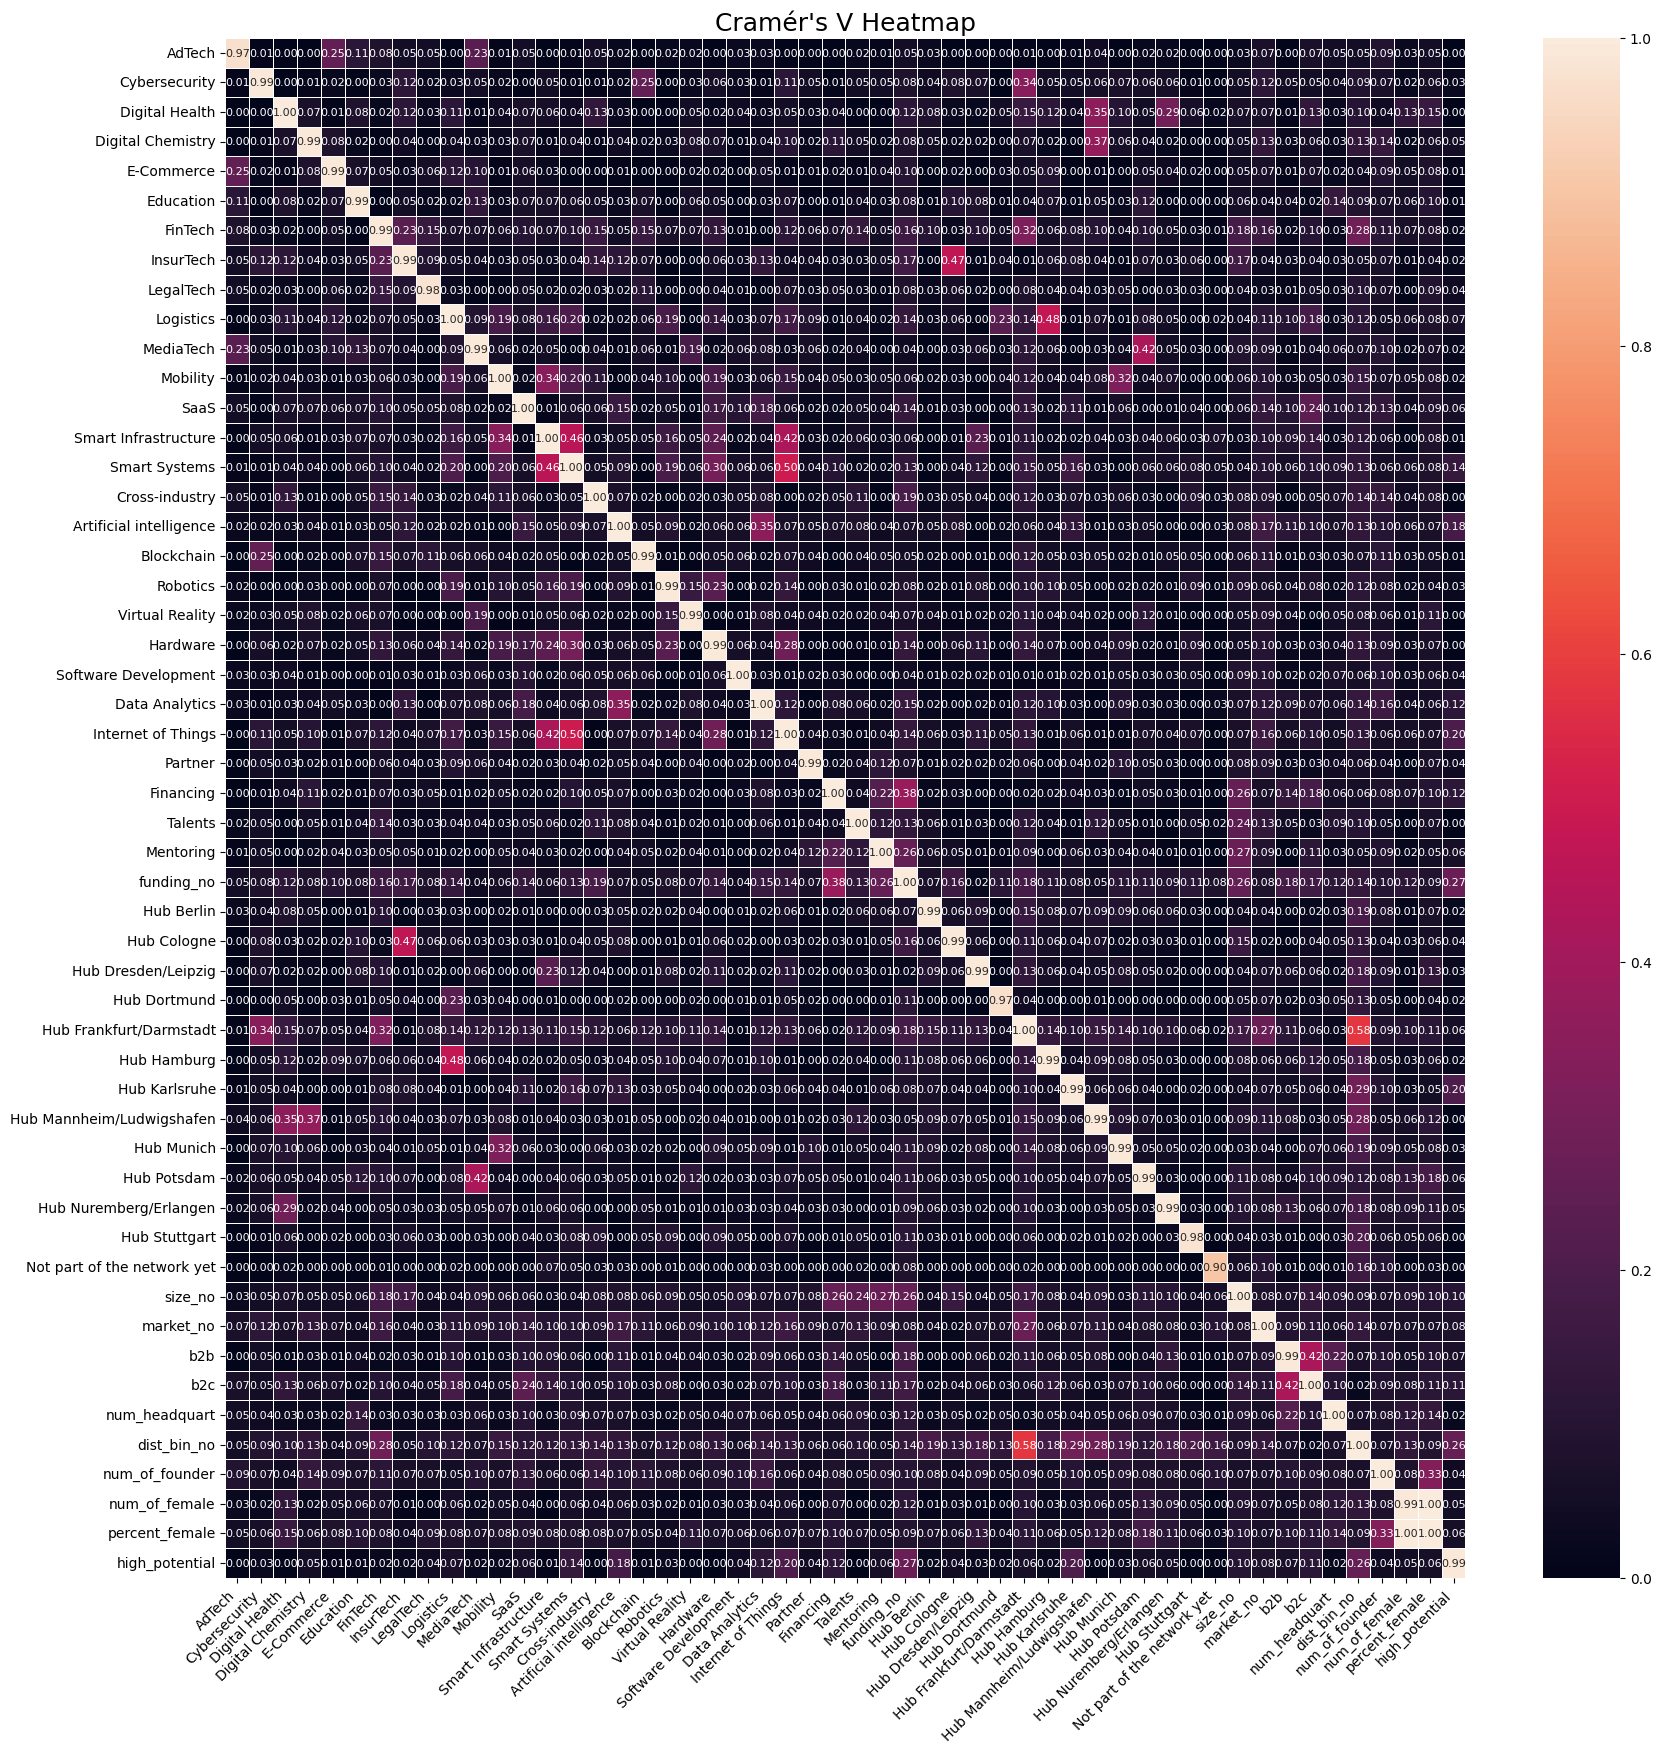

In [213]:
#heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(df1, annot=True, annot_kws={"size": 8}, fmt=".2f", linewidths=0.5)
plt.title("Cramér's V Heatmap", fontsize=18)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Contingency Matrix

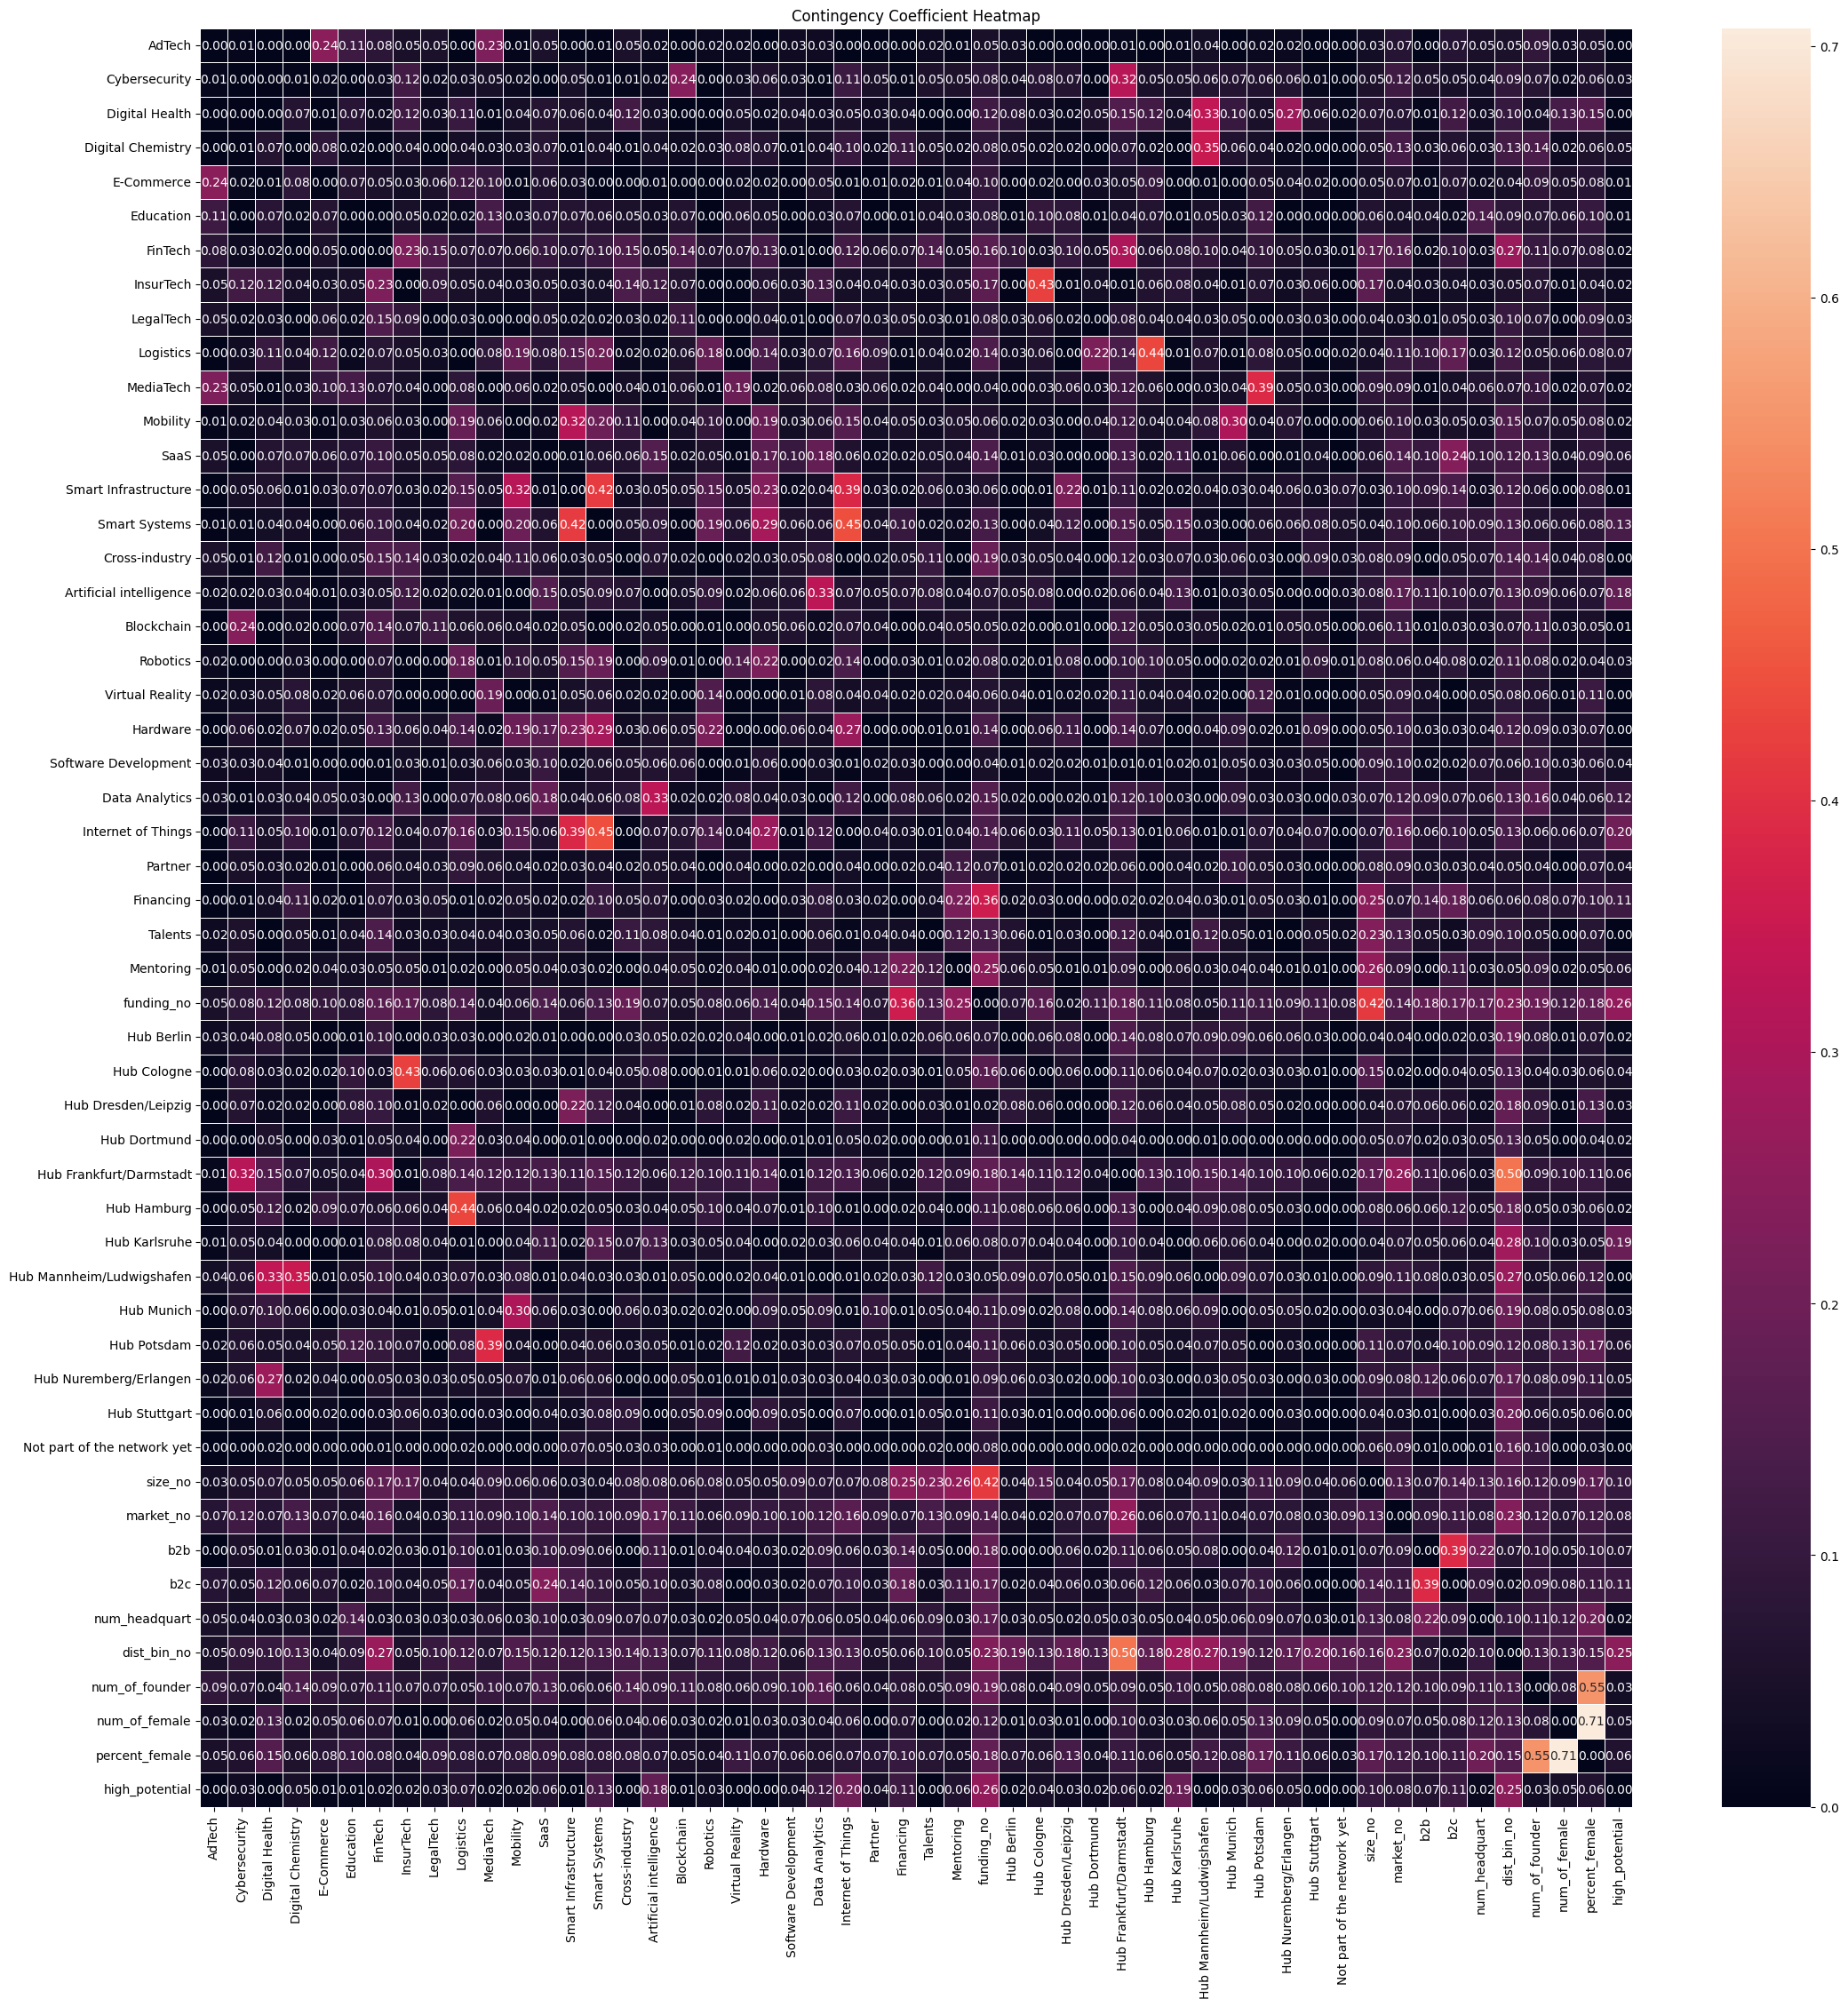

In [214]:
contingency_matrix = np.zeros((num_vars, num_vars))

for i, var1 in enumerate(cate_col.columns):
    for j, var2 in enumerate(cate_col.columns):
        if i != j:  # Exclude the same variables
            contingency_table = pd.crosstab(cate_col[var1], cate_col[var2])
            chi2, _, _, _ = chi2_contingency(contingency_table)
            contingency_coefficient = np.sqrt(chi2 / (chi2 + len(cate_col)))  # Calculate the contingency coefficient
            contingency_matrix[i, j] = contingency_coefficient


contingency_df = pd.DataFrame(contingency_matrix, columns=cate_col.columns, index=cate_col.columns)

plt.figure(figsize=(num_vars // 2, num_vars // 2))

sns.heatmap(contingency_df, annot=True, fmt=".2f", linewidths=.5)

plt.title("Contingency Coefficient Heatmap")
plt.show()

# Feature Selection

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel(r"C:\Users\Admin\Documents\Studio Code\startup_partnerships\data2_after_imputed.xlsx")
df

,AdTech,Cybersecurity,Digital Health,Digital Chemistry,E-Commerce,Education,FinTech,InsurTech,LegalTech,Logistics,...,size_no,funding_no,market_no,num_headquart,dist_A,dist_bin_no,num_of_founder,num_of_female,percent_female,high_potential
0,0,0,0,0,0,0,0,0,0,0,...,1,3,3,1,7.949222,1,1,0,0,0
1,0,0,0,0,1,1,0,0,0,0,...,2,3,3,1,11.129188,1,3,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,3,2,1,318.361436,4,3,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,2,1,1,167.303757,3,1,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,1,1,1,1,184.615765,3,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,0,0,0,0,0,1,0,0,0,0,...,1,1,4,1,305.784653,4,2,0,0,0
751,0,0,0,0,0,0,1,0,0,1,...,2,4,4,1,428.508754,4,2,0,0,0
752,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,428.508754,4,2,1,50,0
753,0,0,0,0,0,0,0,0,0,1,...,1,1,3,1,178.678863,3,1,0,0,1


In [3]:
from sklearn.feature_selection import chi2
X = df.drop(columns=['high_potential'])
y = df['high_potential']

#Use chi-squared to examine the association of
chi_scores, p_values = chi2(X, y)
chi2_df = pd.DataFrame({'Feature': X.columns, 'Chi2': chi_scores, 'P-value': p_values})
chi2_df = chi2_df.sort_values(by=['P-value'], ascending=True)

chi_values = pd.Series(chi_scores, index=X.columns)
chi_values.sort_values(ascending=True, inplace=True)
chi2_df


,Feature,Chi2,P-value
48,dist_A,1.167213e+02,3.303755e-27
52,percent_female,7.218428e+01,1.960114e-17
34,Hub Karlsruhe,2.957173e+01,5.388526e-08
23,Internet of Things,2.377746e+01,1.081417e-06
45,funding_no,1.893362e+01,1.353465e-05
16,Artificial intelligence,1.242812e+01,4.229169e-04
14,Smart Systems,1.159677e+01,6.606629e-04
43,b2c,6.921842e+00,8.514921e-03
22,Data Analytics,5.903370e+00,1.511194e-02
49,dist_bin_no,3.896938e+00,4.837421e-02


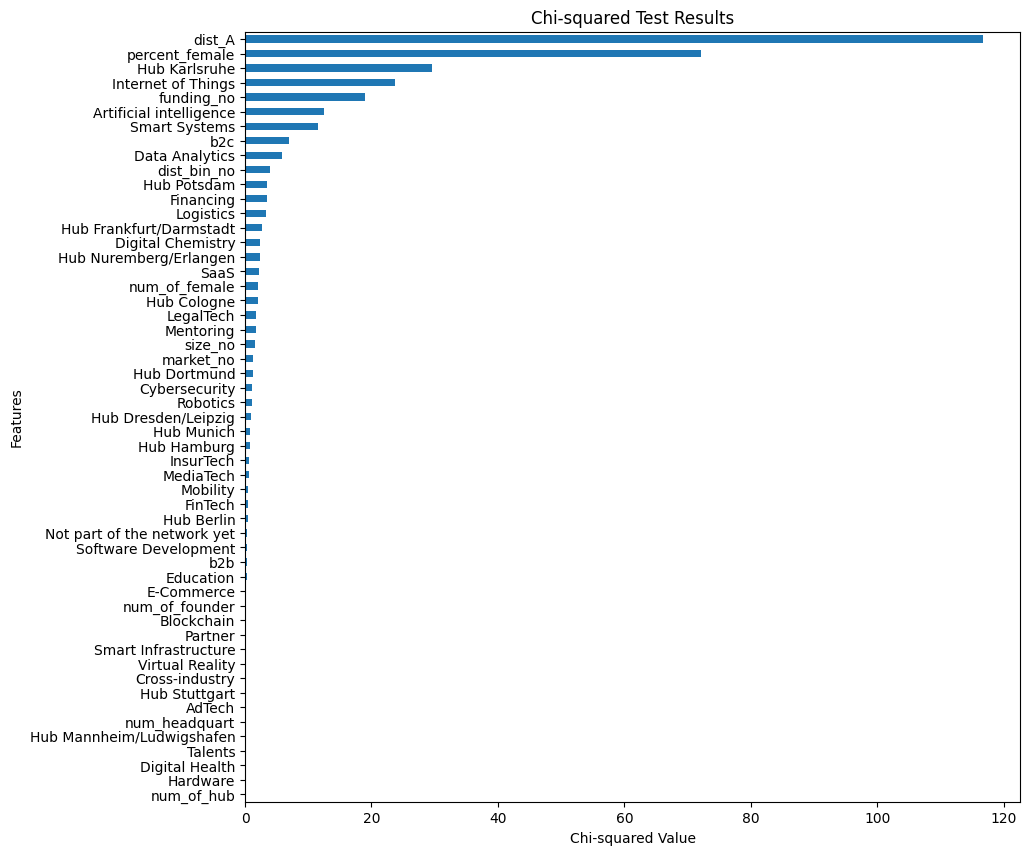

In [4]:
#plot chi2
plt.figure(figsize=(10, 10))
chi_values.plot.barh()
plt.xlabel('Chi-squared Value')
plt.ylabel('Features')
plt.title('Chi-squared Test Results')
plt.show()

In [5]:
df_feature_selection = df[['percent_female', 'Internet of Things','funding_no',
                           'Artificial intelligence','Smart Systems', 'Hub Karlsruhe',
                           'b2c', 'Data Analytics', 'dist_bin_no' ]]

df_feature_selection['high_potential'] = df['high_potential']

df_feature_selection


C:\Users\Admin\AppData\Local\Temp\ipykernel_26000\3184721239.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_selection['high_potential'] = df['high_potential']


,percent_female,Internet of Things,funding_no,Artificial intelligence,Smart Systems,Hub Karlsruhe,b2c,Data Analytics,dist_bin_no,high_potential
0,0,0,3,1,0,0,0,0,1,0
1,0,0,3,0,0,0,0,0,1,0
2,0,0,3,1,1,1,0,0,4,0
3,0,0,2,0,0,0,1,1,3,0
4,0,0,1,0,0,0,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...
750,0,0,1,1,0,0,0,1,4,0
751,0,1,4,0,1,0,0,1,4,0
752,50,1,1,0,1,0,0,0,4,0
753,0,1,1,0,0,1,0,1,3,1


# PCA

In [6]:
# Step 2: PCA with sign alignment
from sklearn.decomposition import PCA
import pandas as pd

# Extract feature groups
features_to_pca_1 = df_feature_selection[['Internet of Things', 'Smart Systems']]
features_to_pca_2 = df_feature_selection[['Data Analytics', 'Artificial intelligence']]
other_features = df_feature_selection.drop(
    columns=['Internet of Things', 'Smart Systems', 'Data Analytics', 'Artificial intelligence', 'high_potential']
)

# PCA for first pair: Internet of Things + Smart Systems
pca_1 = PCA(n_components=1)
pc1_values = pca_1.fit_transform(features_to_pca_1)

# Flip sign if sum of loadings is negative (optional rule)
if pca_1.components_[0].sum() < 0:
    pc1_values *= -1
    pca_1.components_ *= -1

pca_df_1 = pd.DataFrame(pc1_values, columns=['IoT_SmartSystems_PC1'])

# PCA for second pair: Data Analytics + AI
pca_2 = PCA(n_components=1)
pc2_values = pca_2.fit_transform(features_to_pca_2)

# Flip sign if sum of loadings is negative (e.g., if both DA and AI are positively correlated with the outcome)
if pca_2.components_[0].sum() < 0:
    pc2_values *= -1
    pca_2.components_ *= -1

pca_df_2 = pd.DataFrame(pc2_values, columns=['AI_DataAnalytics_PC2'])

# Final dataset
df_final = pd.concat(
    [other_features, pca_df_1, pca_df_2, df_feature_selection[['high_potential']]],
    axis=1
)

print(df_final.head())


   percent_female  funding_no  Hub Karlsruhe  b2c  dist_bin_no  \
0               0           3              0    0            1   
1               0           3              0    0            1   
2               0           3              1    0            4   
3               0           2              0    1            3   
4               0           1              0    0            3   

   IoT_SmartSystems_PC1  AI_DataAnalytics_PC2  high_potential  
0             -0.356631             -0.015485               0  
1             -0.356631             -0.721098               0  
2              0.317886             -0.015485               0  
3             -0.356631             -0.012502               0  
4             -0.356631             -0.721098               0  


In [7]:
# For IoT and Smart Systems (PC1)
print("PCA Loadings for IoT_SmartSystems_PC1:")
print(f"Internet of Things: {pca_1.components_[0][0]:.4f}")
print(f"Smart Systems:     {pca_1.components_[0][1]:.4f}")

# For AI and Data Analytics (PC2)
print("\nPCA Loadings for AI_DataAnalytics_PC2:")
print(f"Data Analytics:         {pca_2.components_[0][0]:.4f}")
print(f"Artificial Intelligence: {pca_2.components_[0][1]:.4f}")


PCA Loadings for IoT_SmartSystems_PC1:
Internet of Things: 0.7383
Smart Systems:     0.6745

PCA Loadings for AI_DataAnalytics_PC2:
Data Analytics:         0.7086
Artificial Intelligence: 0.7056


In [8]:
df_feature_selection = df_final

# NEGATIVE LABELLING (Cluster)

In [9]:
#update 29.05.2025 (reviewing)
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [10]:
#Scale features 
features = [col for col in df_feature_selection.columns if col != 'high_potential']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_feature_selection[features])
X_scaled_df = pd.DataFrame(X_scaled, columns=features)


In [11]:
#Clustering
kmeans = KMeans(n_clusters=10, random_state=42)
df_feature_selection['cluster'] = kmeans.fit_predict(X_scaled)

#choose clusters that DON'T INCLUDE any positive sample
partner_clusters = df_feature_selection[df_feature_selection['high_potential'] == 1]['cluster'].unique()
negative_pool = df_feature_selection[(df_feature_selection['high_potential'] == 0) & (~df_feature_selection['cluster'].isin(partner_clusters))]

len(negative_pool) #=66 negative samples only -> too little

c:\Users\Admin\Documents\Studio Code\col\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


66

In [12]:
#relax the condition: get clusters also for those that have little positive:negative sample ratio
cluster_counts = df_feature_selection.groupby('cluster')['high_potential'].value_counts().unstack().fillna(0)
cluster_counts['positive_ratio'] = cluster_counts[1] / (cluster_counts[0] + cluster_counts[1])

# Keep clusters where MOST samples are NOT positive (6%)
safe_clusters = cluster_counts[cluster_counts['positive_ratio'] < 0.05].index

negative_pool = df_feature_selection[(df_feature_selection['high_potential'] == 0) & (df_feature_selection['cluster'].isin(safe_clusters))]
len(negative_pool)


442

In [13]:
positive_samples = df_feature_selection[df_feature_selection['high_potential'] == 1]
balanced_df = pd.concat([positive_samples, negative_pool]).reset_index(drop=True)
balanced_df

,percent_female,funding_no,Hub Karlsruhe,b2c,dist_bin_no,IoT_SmartSystems_PC1,AI_DataAnalytics_PC2,high_potential,cluster
0,0,3,1,0,3,0.381629,0.693112,1,4
1,0,3,0,0,4,-0.356631,-0.015485,1,6
2,0,1,1,0,3,1.056146,0.693112,1,4
3,0,4,0,0,3,1.056146,-0.015485,1,0
4,0,4,0,0,3,0.381629,-0.015485,1,0
...,...,...,...,...,...,...,...,...,...
490,0,4,0,0,4,-0.356631,-0.721098,0,1
491,0,4,0,1,4,-0.356631,-0.015485,0,2
492,0,2,0,0,4,-0.356631,-0.012502,0,7
493,0,1,0,0,4,-0.356631,0.693112,0,7


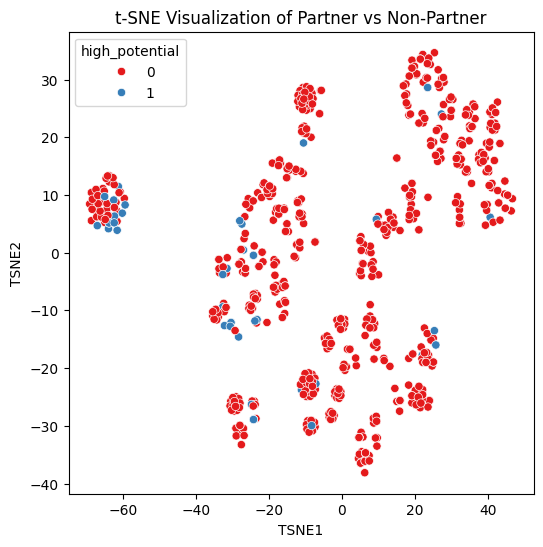

In [14]:
#Visualize clusters
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

df['TSNE1'] = X_tsne[:, 0]
df['TSNE2'] = X_tsne[:, 1]

plt.figure(figsize=(6,6))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='high_potential', palette='Set1')
plt.title("t-SNE Visualization of Partner vs Non-Partner")

plt.show()

# MODELLING

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [16]:
balanced_df_clean = balanced_df.drop_duplicates(subset=balanced_df.columns.difference(['high_potential']))

X = balanced_df_clean.drop(columns=['high_potential', 'cluster'])
y = balanced_df_clean['high_potential']

# Separate positives and negatives
positives = balanced_df_clean[balanced_df_clean['high_potential'] == 1]
negatives = balanced_df_clean[balanced_df_clean['high_potential'] == 0]

# Set desired number of positives and negatives for test set
n_pos_test = 15
n_neg_test = 35

# Sample test set
test_pos = positives.sample(n=n_pos_test, random_state=42)
test_neg = negatives.sample(n=n_neg_test, random_state=42)

df_test = pd.concat([test_pos, test_neg])
df_train = balanced_df_clean.drop(df_test.index)

# Rebuild X/y
X_train = df_train.drop(columns=['high_potential', 'cluster'])
y_train = df_train['high_potential']
X_test = df_test.drop(columns=['high_potential', 'cluster'])
y_test = df_test['high_potential']

print("Training set:\n", y_train.value_counts())
print("Test set:\n", y_test.value_counts())


Training set:
 high_potential
0    155
1     26
Name: count, dtype: int64
Test set:
 high_potential
0    35
1    15
Name: count, dtype: int64


## NO SMOTE

### Logistic Regression

In [17]:
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)
predicted_probs = model_lr.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1
y_pred = model_lr.predict(X_test)
lr_score = accuracy_score(y_test, y_pred)


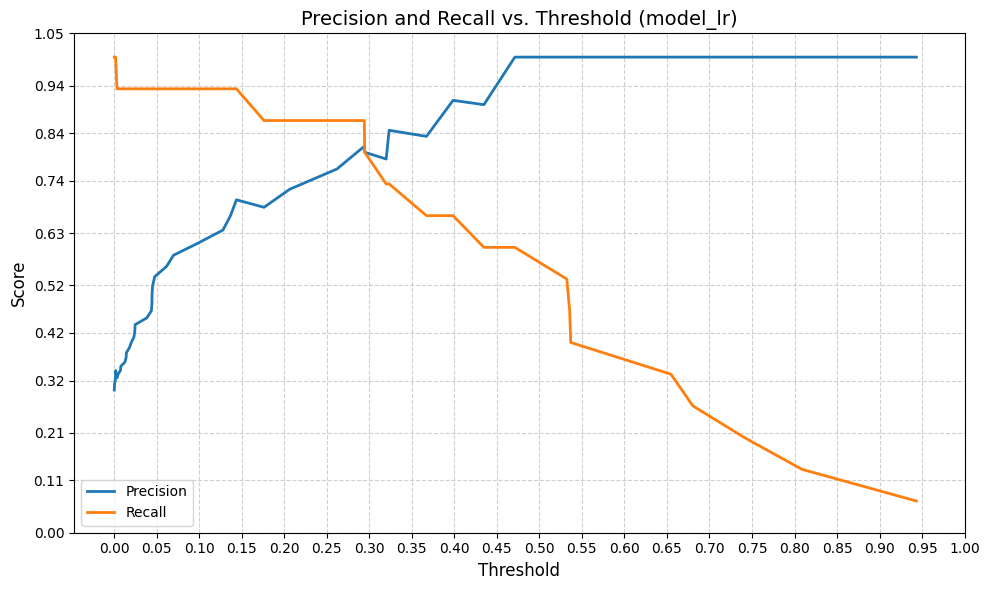

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

#probabilities for class 1
predicted_probs = model_lr.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, predicted_probs)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label="Precision", linewidth=2)
plt.plot(thresholds, recall[:-1], label="Recall", linewidth=2)

plt.xticks(np.round(np.linspace(0, 1, 21), 2))  # Thresholds from 0 to 1
plt.yticks(np.round(np.linspace(0, 1.05, 11), 2))  # Score range

plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Precision and Recall vs. Threshold (model_lr)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc="best")
plt.tight_layout()
plt.show()


In [19]:
report = classification_report(y_test,y_pred, target_names=['Class 0', 'Class 1'])
class1_metrics = report.split('\n\n')[1]
print(class1_metrics)

     Class 0       0.83      1.00      0.91        35
     Class 1       1.00      0.53      0.70        15


In [20]:
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, pos_label=1, average='binary')
class1_metrics = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Support', 'Accuracy'],
    'Logistic Regression': [precision, recall, f1_score, support, lr_score]
})

class1_metrics

,Metric,Logistic Regression
0,Precision,1.000000
1,Recall,0.533333
2,F1-Score,0.695652
3,Support,NaN
4,Accuracy,0.860000


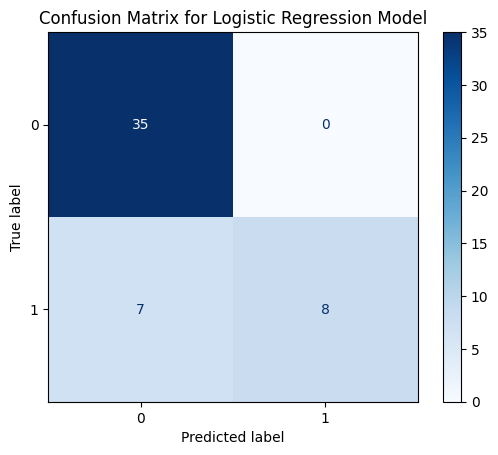

In [21]:

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression Model")
plt.show()

In [22]:
from sklearn.utils import shuffle

duplicates = X.duplicated().sum()
print(f"Total duplicates: {duplicates}")


Total duplicates: 0


In [23]:
#check data leakage
#overlap = set(X_train.index).intersection(set(X_test.index))
#overlap #nothing means no overlap

In [24]:
#differnt models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(max_depth=3, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

metrics = {
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Support', 'Accuracy']
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    precision, recall, f1_score, support = precision_recall_fscore_support(
        y_test, y_pred, pos_label=1, average='binary'
    )
    acc = accuracy_score(y_test, y_pred)

    metrics[name] = [precision, recall, f1_score, support, acc]

class1_metrics = pd.DataFrame(metrics)
class1_metrics

c:\Users\Admin\Documents\Studio Code\col\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:13:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Admin\Documents\Studio Code\col\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Metric,Logistic Regression,Random Forest,XGBoost,SVM
0,Precision,1.000000,1.000000,1.000000,0.0
1,Recall,0.533333,0.200000,0.800000,0.0
2,F1-Score,0.695652,0.333333,0.888889,0.0
3,Support,NaN,NaN,NaN,NaN
4,Accuracy,0.860000,0.760000,0.940000,0.7


In [25]:
#test using kfold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000))
    ]),
    "Random Forest": RandomForestClassifier(max_depth=5, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=5, random_state=42),
    "SVM": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(probability=True))
    ])
}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='precision')
    print(f"{name}: mean precision = {scores.mean():.3f}, std = {scores.std():.3f}")


Logistic Regression: mean precision = 0.862, std = 0.074
Random Forest: mean precision = 0.975, std = 0.050


c:\Users\Admin\Documents\Studio Code\col\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:13:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Admin\Documents\Studio Code\col\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:13:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Admin\Documents\Studio Code\col\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:13:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Admin\Documents\Studio Code\col\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:13:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Par

XGBoost: mean precision = 0.931, std = 0.086
SVM: mean precision = 1.000, std = 0.000


c:\Users\Admin\Documents\Studio Code\col\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:13:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Modelling (with resampling SMOTE)

### Prevent data leakage


In [26]:
# Drop cluster column
balanced_df = balanced_df.drop(columns=['cluster'], errors='ignore')

#Remove dups = dedup_df
dedup_df = balanced_df.drop_duplicates()

# Sample test set from deduplicated positives and negatives
positives = dedup_df[dedup_df['high_potential'] == 1]
negatives = dedup_df[dedup_df['high_potential'] == 0]

n_pos_test = 30 #wanted positives in test set
n_neg_test = 70 #wanted negatives
test_pos = positives.sample(n=n_pos_test, random_state=42)
test_neg = negatives.sample(n=n_neg_test, random_state=42)

df_test = pd.concat([test_pos, test_neg]).reset_index(drop=True) #--> Test set

# Drop all rows in balanced_df that are exact matches with df_test (based on all columns)
join_cols = balanced_df.columns.tolist()
df_train = balanced_df.merge(df_test, on=join_cols, how='outer', indicator=True)
df_train = df_train[df_train['_merge'] == 'left_only'].drop(columns=['_merge']) #take the rest excluding those from test set

# Rebuild X/y
X_train = df_train.drop(columns=['high_potential'])
y_train = df_train['high_potential']
X_test = df_test.drop(columns=['high_potential'])
y_test = df_test['high_potential']


In [45]:
y_train.value_counts()

high_potential
0    632
1     48
Name: count, dtype: int64

In [27]:
# SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority', random_state=42) #define smote
oversampled_X, oversampled_Y = sm.fit_resample(X_train, y_train) #fit SMOTE model to df_train

oversampled = pd.concat([
    pd.DataFrame(oversampled_Y, columns=['high_potential']),
    pd.DataFrame(oversampled_X, columns=X_train.columns)
], axis=1).reset_index(drop=True)

#leakage check
leakage_rows = pd.merge(
    X_test.reset_index(drop=True),
    pd.DataFrame(oversampled_X, columns=X_train.columns),
    how='inner'
)
print("Leakage rows (should be 0):", len(leakage_rows))


Leakage rows (should be 0): 11


In [28]:
oversampled_Y.value_counts()

high_potential
1    280
0    280
Name: count, dtype: int64

### Logistic Regression

In [29]:
#threshold 0.5
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(random_state=42) #model: LR that applied after SMOTE
model.fit(oversampled_X, oversampled_Y)

y_pred = model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.867     0.929     0.897        70
           1      0.800     0.667     0.727        30

    accuracy                          0.850       100
   macro avg      0.833     0.798     0.812       100
weighted avg      0.847     0.850     0.846       100



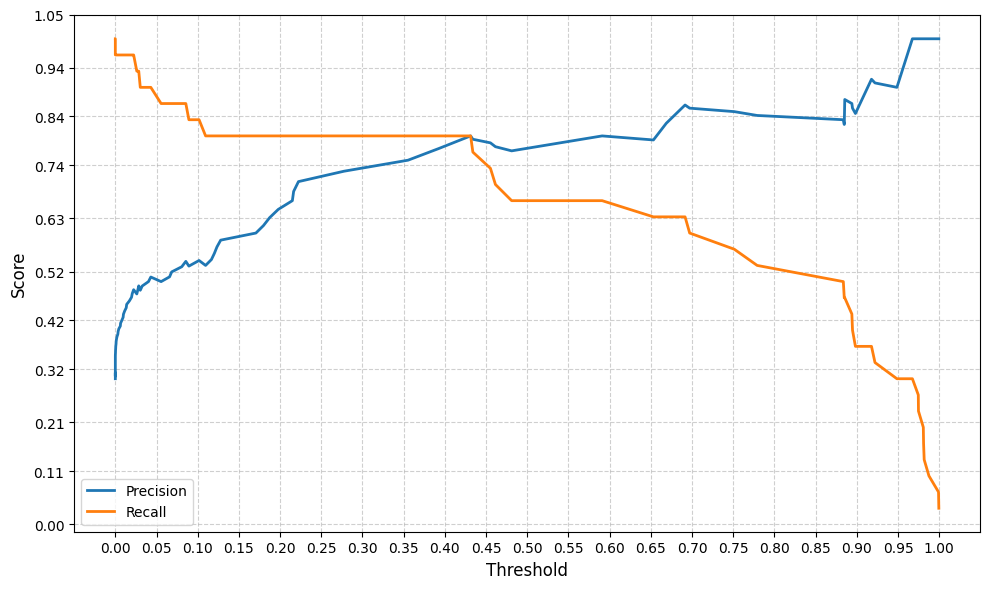

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

#Get probs for Class 1 predictions
probs = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)

#plot pr vs rec curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', linewidth=2)
plt.plot(thresholds, recall[:-1], label='Recall', linewidth=2)

plt.xticks(np.round(np.linspace(0, 1, 21), 2))  # Threshold ticks: 0.00 to 1.00
plt.yticks(np.round(np.linspace(0, 1.05, 11), 2))  # Score ticks: 0.0 to 1.0

plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [31]:
# custom threshold 
threshold = 0.69
y_pred_custom = (probs >= threshold).astype(int)

# Evaluation
print(f"Classification Report (threshold = {threshold}):")
print(classification_report(y_test, y_pred_custom, digits=3))


Classification Report (threshold = 0.69):
              precision    recall  f1-score   support

           0      0.859     0.957     0.905        70
           1      0.864     0.633     0.731        30

    accuracy                          0.860       100
   macro avg      0.861     0.795     0.818       100
weighted avg      0.860     0.860     0.853       100



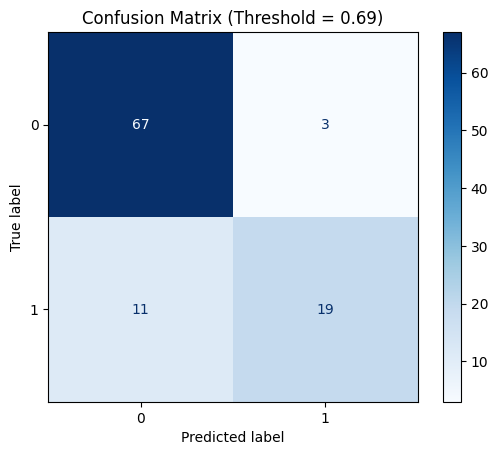

Accuracy at threshold 0.69: 0.860


In [32]:
#confusion matrix (at the above-decided threshold)
cm = confusion_matrix(y_test, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)

plt.title(f"Confusion Matrix (Threshold = {threshold})")
plt.grid(False)
plt.show()

# Optional: print accuracy
acc = accuracy_score(y_test, y_pred_custom)
print(f"Accuracy at threshold {threshold}: {acc:.3f}")


# Interpret LR

In [33]:
# Get coefficients
coefficients = model.coef_[0]  # Get the array of coefficients
feature_names = oversampled_X.columns  
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})

coef_df

,Feature,Coefficient
0,percent_female,-0.191285
1,funding_no,2.103200
2,Hub Karlsruhe,0.385790
3,b2c,-1.210750
4,dist_bin_no,-0.738022
5,IoT_SmartSystems_PC1,2.248251
6,AI_DataAnalytics_PC2,2.820262


In [34]:
# Sort by the absolute value of coefficients
coef_df['coefficient_abs'] = coef_df['Coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='coefficient_abs', ascending=False)

coef_df_sorted

,Feature,Coefficient,coefficient_abs
6,AI_DataAnalytics_PC2,2.820262,2.820262
5,IoT_SmartSystems_PC1,2.248251,2.248251
1,funding_no,2.103200,2.103200
3,b2c,-1.210750,1.210750
4,dist_bin_no,-0.738022,0.738022
2,Hub Karlsruhe,0.385790,0.385790
0,percent_female,-0.191285,0.191285


In [35]:
#LR by statsmodels
import statsmodels.api as sm

X_train_sm = sm.add_constant(pd.DataFrame(oversampled_X).reset_index(drop=True))
y_train_sm = pd.Series(oversampled_Y).reset_index(drop=True)

model_sm = sm.Logit(y_train_sm, X_train_sm).fit()
print(model_sm.summary())



         Current function value: 0.114872
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:         high_potential   No. Observations:                  560
Model:                          Logit   Df Residuals:                      552
Method:                           MLE   Df Model:                            7
Date:                Tue, 03 Jun 2025   Pseudo R-squ.:                  0.8343
Time:                        14:13:43   Log-Likelihood:                -64.328
converged:                      False   LL-Null:                       -388.16
Covariance Type:            nonrobust   LLR p-value:                1.313e-135
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -6.5283      1.486     -4.393      0.000      -9.441      -3.616
percent_female          -3.0365   3

c:\Users\Admin\Documents\Studio Code\col\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
summary_df = pd.DataFrame({
    'Coefficient': model_sm.params,
    'Std. Error': model_sm.bse,
    'Odds Ratio': np.exp(model_sm.params),
    'P-Value': model_sm.pvalues
}).round(4)

summary_df = summary_df.sort_values(by='P-Value')

print(summary_df)

                      Coefficient    Std. Error    Odds Ratio  P-Value
const                     -6.5283  1.486100e+00  1.500000e-03   0.0000
funding_no                 2.5808  3.372000e-01  1.320780e+01   0.0000
IoT_SmartSystems_PC1       2.9878  6.746000e-01  1.984240e+01   0.0000
AI_DataAnalytics_PC2       3.6410  5.496000e-01  3.813070e+01   0.0000
b2c                       -1.5406  5.256000e-01  2.143000e-01   0.0034
dist_bin_no               -0.7589  3.532000e-01  4.682000e-01   0.0317
Hub Karlsruhe             24.7601  3.605972e+05  5.664660e+10   0.9999
percent_female            -3.0365  3.216514e+12  4.800000e-02   1.0000


In [37]:
print(summary_df)

                      Coefficient    Std. Error    Odds Ratio  P-Value
const                     -6.5283  1.486100e+00  1.500000e-03   0.0000
funding_no                 2.5808  3.372000e-01  1.320780e+01   0.0000
IoT_SmartSystems_PC1       2.9878  6.746000e-01  1.984240e+01   0.0000
AI_DataAnalytics_PC2       3.6410  5.496000e-01  3.813070e+01   0.0000
b2c                       -1.5406  5.256000e-01  2.143000e-01   0.0034
dist_bin_no               -0.7589  3.532000e-01  4.682000e-01   0.0317
Hub Karlsruhe             24.7601  3.605972e+05  5.664660e+10   0.9999
percent_female            -3.0365  3.216514e+12  4.800000e-02   1.0000


# Other models

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
import pandas as pd

# Define models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(oversampled_X, oversampled_Y)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # For ROC-AUC

    # Metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, pos_label=1, average='binary')
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results.append({
        "Model": name,
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1-Score": round(f1, 3),
        "Accuracy": round(accuracy, 3),
        "ROC-AUC": round(roc_auc, 3)
    })

# Results as DataFrame
results_df = pd.DataFrame(results).set_index("Model")
display(results_df)


c:\Users\Admin\Documents\Studio Code\col\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:13:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Precision,Recall,F1-Score,Accuracy,ROC-AUC
Model,,,,,
Logistic Regression,0.800,0.667,0.727,0.85,0.882
Random Forest,1.000,0.433,0.605,0.83,0.910
XGBoost,1.000,0.533,0.696,0.86,0.901
SVM,0.719,0.767,0.742,0.84,0.882


c:\Users\Admin\Documents\Studio Code\col\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:13:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


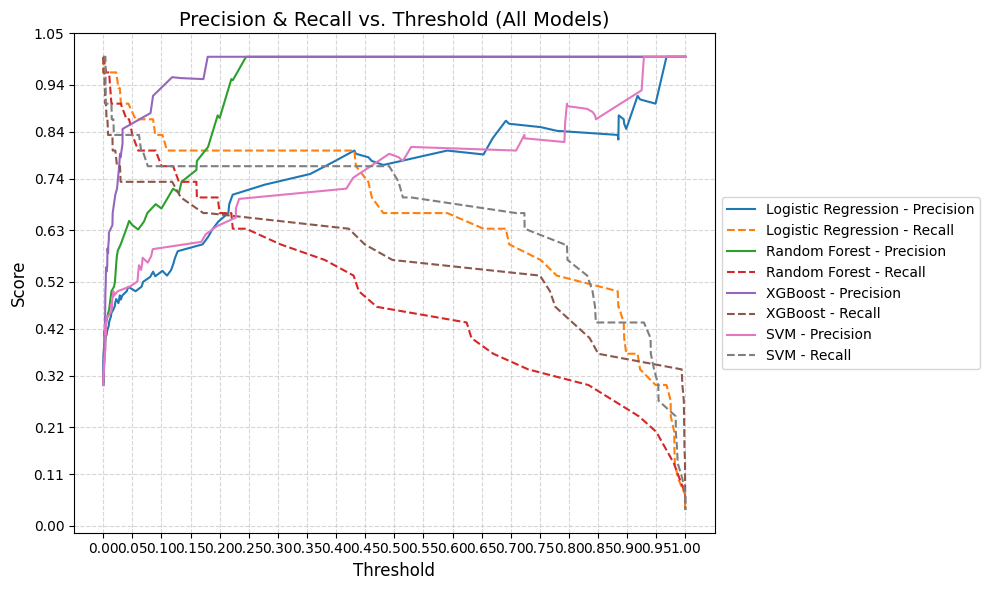

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Models already trained
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# Train all models first
probs_dict = {}

for name, model in models.items():
    model.fit(oversampled_X, oversampled_Y)
    probs = model.predict_proba(X_test)[:, 1]  # Get prob for class 1
    probs_dict[name] = probs

# Plotting
plt.figure(figsize=(10, 6))

for name, probs in probs_dict.items():
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    plt.plot(thresholds, precision[:-1], label=f'{name} - Precision')
    plt.plot(thresholds, recall[:-1], linestyle='--', label=f'{name} - Recall')

plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Precision & Recall vs. Threshold (All Models)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(np.round(np.linspace(0, 1, 21), 2))
plt.yticks(np.round(np.linspace(0, 1.05, 11), 2))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


c:\Users\Admin\Documents\Studio Code\col\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:13:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                     Best Threshold  Precision  Recall  F1-Score  Accuracy  \
Model                                                                        
Logistic Regression            0.43      0.800   0.800     0.800      0.88   
Random Forest                  0.22      0.952   0.667     0.784      0.89   
XGBoost                        0.12      0.957   0.733     0.830      0.91   
SVM                            0.49      0.793   0.767     0.780      0.87   

                     ROC-AUC  
Model                         
Logistic Regression    0.882  
Random Forest          0.910  
XGBoost                0.901  
SVM                    0.882  


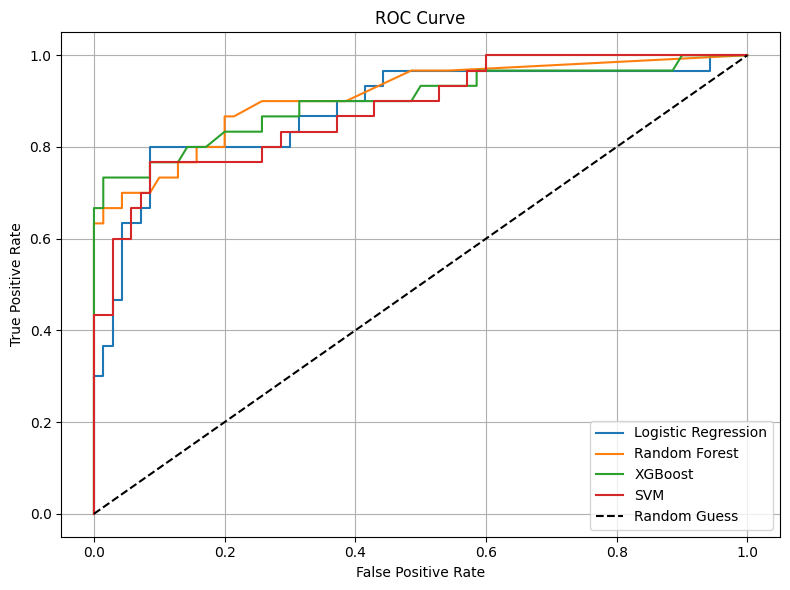

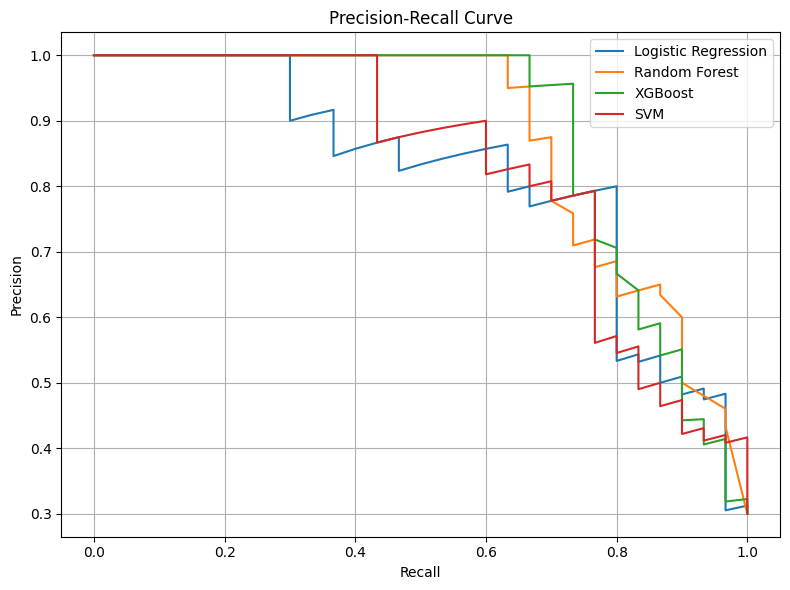

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)

models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

metrics_summary = []
roc_curves = {}
pr_curves = {}

# Train and compute metrics
for name, model in models.items():
    model.fit(oversampled_X, oversampled_Y)
    probs = model.predict_proba(X_test)[:, 1]

    # ROC and PR curves
    fpr, tpr, _ = roc_curve(y_test, probs)
    precision, recall, thresholds = precision_recall_curve(y_test, probs)

    # Best F1 threshold
    f1s = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1s)
    best_thresh = thresholds[best_idx]
    best_f1 = f1s[best_idx]

    # Predict at best threshold
    final_preds = (probs >= best_thresh).astype(int)

    # Metrics
    prec = precision_score(y_test, final_preds, zero_division=0)
    rec = recall_score(y_test, final_preds, zero_division=0)
    auc = roc_auc_score(y_test, probs)
    acc = accuracy_score(y_test, final_preds)

    # Store results
    metrics_summary.append({
        "Model": name,
        "Best Threshold": round(best_thresh, 2),
        "Precision": round(prec, 3),
        "Recall": round(rec, 3),
        "F1-Score": round(best_f1, 3),
        "Accuracy": round(acc, 3),
        "ROC-AUC": round(auc, 3)
    })

    roc_curves[name] = (fpr, tpr)
    pr_curves[name] = (recall, precision)

# Convert to DataFrame and display
metrics_df = pd.DataFrame(metrics_summary).set_index("Model")
print(metrics_df)

# Plot ROC curves
plt.figure(figsize=(8, 6))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Precision-Recall curves
plt.figure(figsize=(8, 6))
for name, (recall, precision) in pr_curves.items():
    plt.plot(recall, precision, label=f"{name}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# ROC - AUC

In [41]:
log_prob = model.predict_proba(X_test)
log_probs = log_prob[:, 1]
fpr, tpr, _ = roc_curve(y_test, log_probs)
log_auc=roc_auc_score(y_test, log_probs)
log_auc

0.881904761904762

# Validation

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

# Set data
X = balanced_df.drop(columns=['high_potential'])
y = balanced_df['high_potential']

# Settings
n_repeats = 5
threshold = 0.7

# Store metrics
all_metrics = {
    'Run': [],
    'Precision': [],
    'Recall': [],
    'F1-score': [],
    'ROC-AUC': []
}

for i in range(n_repeats):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42 + i
    )

    # SMOTE on training 
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    #Train
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_res, y_train_res)

    # Predict
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    # Evaluate
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba)

    all_metrics['Run'].append(i + 1)
    all_metrics['Precision'].append(prec)
    all_metrics['Recall'].append(rec)
    all_metrics['F1-score'].append(f1)
    all_metrics['ROC-AUC'].append(roc)

    print(f"Run {i+1}: Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}, ROC-AUC={roc:.3f}")

df_metrics = pd.DataFrame(all_metrics)

summary = pd.DataFrame({
    'Run': ['Mean', 'Std Dev'],
    'Precision': [df_metrics['Precision'].mean(), df_metrics['Precision'].std()],
    'Recall': [df_metrics['Recall'].mean(), df_metrics['Recall'].std()],
    'F1-score': [df_metrics['F1-score'].mean(), df_metrics['F1-score'].std()],
    'ROC-AUC': [df_metrics['ROC-AUC'].mean(), df_metrics['ROC-AUC'].std()],
})

df_metrics = pd.concat([df_metrics, summary], ignore_index=True)

df_metrics



Run 1: Precision=0.636, Recall=0.636, F1=0.636, ROC-AUC=0.891
Run 2: Precision=0.778, Recall=0.636, F1=0.700, ROC-AUC=0.887
Run 3: Precision=0.818, Recall=0.818, F1=0.818, ROC-AUC=0.915
Run 4: Precision=0.900, Recall=0.818, F1=0.857, ROC-AUC=0.928
Run 5: Precision=0.667, Recall=0.909, F1=0.769, ROC-AUC=0.989


,Run,Precision,Recall,F1-score,ROC-AUC
0,1,0.636364,0.636364,0.636364,0.891012
1,2,0.777778,0.636364,0.700000,0.887397
2,3,0.818182,0.818182,0.818182,0.915289
3,4,0.900000,0.818182,0.857143,0.928202
4,5,0.666667,0.909091,0.769231,0.988636
5,Mean,0.759798,0.763636,0.756184,0.922107
6,Std Dev,0.108741,0.121967,0.089051,0.040870


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

# Set data
X = balanced_df.drop(columns=['high_potential'])
y = balanced_df['high_potential']

# Settings
n_repeats = 5
threshold = 0.7

# Store metrics
all_metrics = {
    'Run': [],
    'Precision': [],
    'Recall': [],
    'F1-score': [],
    'ROC-AUC': [],
    'Accuracy': []
}

for i in range(n_repeats):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42 + i
    )

    # SMOTE on training 
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Train
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_res, y_train_res)

    # Predict
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    # Evaluate
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)

    all_metrics['Run'].append(i + 1)
    all_metrics['Precision'].append(prec)
    all_metrics['Recall'].append(rec)
    all_metrics['F1-score'].append(f1)
    all_metrics['ROC-AUC'].append(roc)
    all_metrics['Accuracy'].append(acc)

    print(f"Run {i+1}: Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}, ROC-AUC={roc:.3f}, Accuracy={acc:.3f}")

# Build result table
df_metrics = pd.DataFrame(all_metrics)

# Add summary row
summary = pd.DataFrame({
    'Run': ['Mean', 'Std Dev'],
    'Precision': [df_metrics['Precision'].mean(), df_metrics['Precision'].std()],
    'Recall': [df_metrics['Recall'].mean(), df_metrics['Recall'].std()],
    'F1-score': [df_metrics['F1-score'].mean(), df_metrics['F1-score'].std()],
    'ROC-AUC': [df_metrics['ROC-AUC'].mean(), df_metrics['ROC-AUC'].std()],
    'Accuracy': [df_metrics['Accuracy'].mean(), df_metrics['Accuracy'].std()],
})

df_metrics = pd.concat([df_metrics, summary], ignore_index=True)

df_metrics


Run 1: Precision=0.636, Recall=0.636, F1=0.636, ROC-AUC=0.891, Accuracy=0.919
Run 2: Precision=0.778, Recall=0.636, F1=0.700, ROC-AUC=0.887, Accuracy=0.939
Run 3: Precision=0.818, Recall=0.818, F1=0.818, ROC-AUC=0.915, Accuracy=0.960
Run 4: Precision=0.900, Recall=0.818, F1=0.857, ROC-AUC=0.928, Accuracy=0.970
Run 5: Precision=0.667, Recall=0.909, F1=0.769, ROC-AUC=0.989, Accuracy=0.939


,Run,Precision,Recall,F1-score,ROC-AUC,Accuracy
0,1,0.636364,0.636364,0.636364,0.891012,0.919192
1,2,0.777778,0.636364,0.700000,0.887397,0.939394
2,3,0.818182,0.818182,0.818182,0.915289,0.959596
3,4,0.900000,0.818182,0.857143,0.928202,0.969697
4,5,0.666667,0.909091,0.769231,0.988636,0.939394
5,Mean,0.759798,0.763636,0.756184,0.922107,0.945455
6,Std Dev,0.108741,0.121967,0.089051,0.040870,0.019690


### Graph ROCAUC and PRAUC 

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import numpy as np
import pandas as pd

X = df_feature_selection.drop(columns=['high_potential'])
y = df_feature_selection['high_potential']
model_lr = LogisticRegression(random_state=42)

threshold = 0.50
k = 10
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# To store results
results = {
    'Fold': [],
    'Precision@0.75': [],
    'Recall@0.75': [],
    'AUC-ROC': []
}

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model_lr.fit(X_train, y_train)
    y_pred_proba = model_lr.predict_proba(X_test)[:, 1]

    # Apply custom threshold
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)

    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba)

    results['Fold'].append(fold)
    results['Precision@0.75'].append(precision)
    results['Recall@0.75'].append(recall)
    results['AUC-ROC'].append(auc)

df_kfold_results = pd.DataFrame(results)
df_kfold_results



,Fold,Precision@0.75,Recall@0.75,AUC-ROC
0,1,1.000000,0.200000,0.712676
1,2,0.000000,0.000000,0.897183
2,3,0.500000,0.166667,0.646429
3,4,1.000000,0.333333,0.940476
4,5,0.000000,0.000000,0.888095
5,6,1.000000,0.200000,0.885714
6,7,0.666667,0.400000,0.828571
7,8,0.500000,0.200000,0.882857
8,9,0.500000,0.200000,0.962857
9,10,1.000000,0.400000,0.997143


🔍 Classification Report @ 0.5 threshold:
              precision    recall  f1-score   support

           0      0.867     0.929     0.897        70
           1      0.800     0.667     0.727        30

    accuracy                          0.850       100
   macro avg      0.833     0.798     0.812       100
weighted avg      0.847     0.850     0.846       100

ROC AUC: 0.882


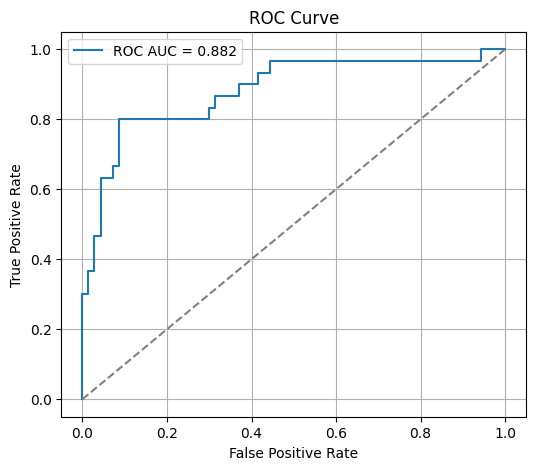

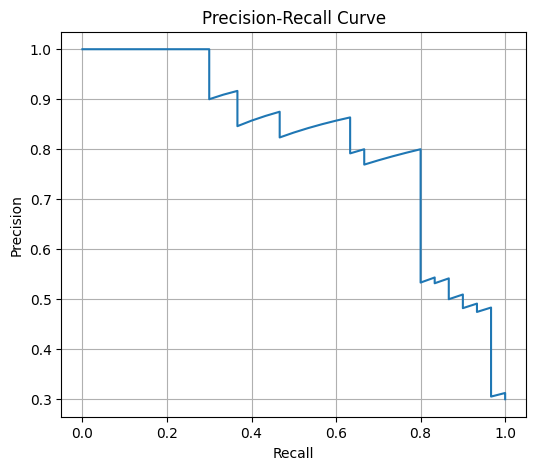

In [415]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, classification_report
)
import matplotlib.pyplot as plt

# Step 1: Train on oversampled data
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(oversampled_X, oversampled_Y)

# Step 2: Predict probabilities on held-out test set
y_probs = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred_05 = (y_probs >= 0.5).astype(int)

# Step 3: Print evaluation metrics
print("🔍 Classification Report @ 0.5 threshold:")
print(classification_report(y_test, y_pred_05, digits=3))

# Step 4: AUC scores
roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC AUC: {roc_auc:.3f}")

# Step 5: Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Step 6: Plot Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_probs)
plt.figure(figsize=(6, 5))
plt.plot(rec, prec, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


# Graphs (discussion)

In [ ]:
df_ori = pd.read_excel('Germany Startups Dataset.xlsx', sheet_name='Encoded')
df_ori

,No.,Company,Industry,AdTech,Cybersecurity,Digital Health,Digital Chemistry,E-Commerce,Education,FinTech,...,num_headquart,dist_bin,dist_bin_no,Startup founders,num_of_founder,num_of_female,percent_female,Website,Email,high_potential
0,1,1A Robotics,Cross-industry,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,Very Close,1,Manquel Tejeda Neira,1,0,0.0,http://www.1arobotics.com,manquel(at)(one)arobotics.com,0
1,2,2VizCon,"MediaTech, Education, E-Commerce",0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,Very Close,1,"Walter Scheuer, Oliver Turnbull, Wryland Reed",3,0,0.0,https://2viz.io,walter(at)(two)viz.io,0
2,3,3dvisionlabs GmbH,Smart Systems,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,Far,4,"Dr. Michel Findeisen, Lars Meinel, Markus Hess",3,0,0.0,https://3dvisionlabs.com/,info(at)(three)dvisionlabs.com,0
3,4,4mobil,SaaS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,Commutable,3,Sakir Kürt,1,0,0.0,https://4mobil.de/,sk(at)werkelf.com,0
4,5,Acalta GmbH,"Digital Health, SaaS",0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,Commutable,3,"Frederik Kaul, Nico Ploner, Simon Winkler",3,0,0.0,https://www.acalta.de/,info(at)acalta(dot)de,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,751,Zesavi,"MediaTech, Education, SaaS, Cross-Industry",0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,Far,4,"Maximilian Zeyda, Edwin Sauer",2,0,0.0,https://zesavi.com,founder(at)zesavi(dot)com,0
751,752,ZF Car eWallet GmbH,"Logistics, FinTech, Mobility, Smart Systems, S...",0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1,Far,4,Thorsten Weber + ZF Friedrichshafen AG,2,0,0.0,http://www.car-ewallet.de,thorsten(dot)weber(at)car-ewallet(dot)de,0
752,753,zkSystems,"SaaS, Smart Systems, Smart Infrastructure",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,Far,4,"Diana Rees, CEO, Amine Ünal, CTO",2,1,50.0,http://zksystems.io,info(at)zksystems.io,0
753,754,Zolitron Technology,"Logistics, SaaS",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,Commutable,3,Arndt-Hendrik Zinn,1,0,0.0,https://zolitron.com/,info(at)zolitron(dot)com,1


In [ ]:
df['lat'] = df_ori['Latitude']
df['lng'] = df_ori['Longitude']
df

,AdTech,Cybersecurity,Digital Health,Digital Chemistry,E-Commerce,Education,FinTech,InsurTech,LegalTech,Logistics,...,market_no,num_headquart,dist_A,dist_bin_no,num_of_founder,num_of_female,percent_female,high_potential,lat,lng
0,0,0,0,0,0,0,0,0,0,0,...,3,1,7.949222,1,1,0,0,0,50.110644,8.682092
1,0,0,0,0,1,1,0,0,0,0,...,3,1,11.129188,1,3,0,0,0,50.046420,8.671775
2,0,0,0,0,0,0,0,0,0,0,...,2,1,318.361436,4,3,0,0,0,50.832353,12.918914
3,0,0,0,0,0,0,0,0,0,0,...,1,1,167.303757,3,1,0,0,0,51.500704,7.618643
4,0,0,1,0,0,0,0,0,0,0,...,1,1,184.615765,3,3,0,0,0,49.592862,11.005600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,0,0,0,0,0,1,0,0,0,0,...,4,1,305.784653,4,2,0,0,0,47.519975,9.912666
751,0,0,0,0,0,0,1,0,0,1,...,4,1,428.508754,4,2,0,0,0,52.510885,13.398937
752,0,0,0,0,0,0,0,0,0,0,...,3,1,428.508754,4,2,1,50,0,52.510885,13.398937
753,0,0,0,0,0,0,0,0,0,1,...,3,1,178.678863,3,1,0,0,1,51.481811,7.219664


In [ ]:
df_feature_selection = df[['percent_female', 'Internet of Things','funding_no',
                           'Artificial intelligence','Smart Systems', 'Hub Karlsruhe',
                           'b2c', 'Data Analytics', 'dist_bin_no','lat','lng' ]]

df_feature_selection['high_potential'] = df['high_potential']

df_feature_selection


<ipython-input-81-8eb04fce2b80>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_selection['high_potential'] = df['high_potential']


,percent_female,Internet of Things,funding_no,Artificial intelligence,Smart Systems,Hub Karlsruhe,b2c,Data Analytics,dist_bin_no,lat,lng,high_potential
0,0,0,3,1,0,0,0,0,1,50.110644,8.682092,0
1,0,0,3,0,0,0,0,0,1,50.046420,8.671775,0
2,0,0,3,1,1,1,0,0,4,50.832353,12.918914,0
3,0,0,2,0,0,0,1,1,3,51.500704,7.618643,0
4,0,0,1,0,0,0,0,0,3,49.592862,11.005600,0
...,...,...,...,...,...,...,...,...,...,...,...,...
750,0,0,1,1,0,0,0,1,4,47.519975,9.912666,0
751,0,1,4,0,1,0,0,1,4,52.510885,13.398937,0
752,50,1,1,0,1,0,0,0,4,52.510885,13.398937,0
753,0,1,1,0,0,1,0,1,3,51.481811,7.219664,1


In [ ]:
#2 PCA
from sklearn.decomposition import PCA

# Select the correlated feature pairs for PCA
features_to_pca_1 = df_feature_selection[['Internet of Things', 'Smart Systems']]
features_to_pca_2 = df_feature_selection[['Data Analytics', 'Artificial intelligence']]


# Keep the other features (excluding the correlated ones and the target variable)
other_features = df_feature_selection.drop(columns=['Internet of Things', 'Smart Systems', 'Data Analytics', 'Artificial intelligence', 'high_potential'])

# Apply PCA to the first pair of features
pca_1 = PCA(n_components=1)
principal_components_1 = pca_1.fit_transform(features_to_pca_1)
pca_df_1 = pd.DataFrame(principal_components_1, columns=['IoT_SmartSystems_PC1'])

# Apply PCA to the second pair of features
pca_2 = PCA(n_components=1)
principal_components_2 = pca_2.fit_transform(features_to_pca_2)
pca_df_2 = pd.DataFrame(principal_components_2, columns=['AI_DataAnalytics_PC2'])


# Combine PCA components, other features, and target variable into the final DataFrame
df_final = pd.concat([other_features, pca_df_1, pca_df_2, df_feature_selection[['high_potential']]], axis=1)

# Display the resulting DataFrame

df_feature_selection = df_final

In [ ]:
from sklearn.model_selection import train_test_split

# Stratified split to maintain proportions of the target variable
df_train, df_test = train_test_split(df_feature_selection,
                                     train_size=0.7,
                                     test_size=0.3,
                                     random_state=100,
                                     stratify=df_feature_selection['high_potential'])

# Separate target variable and features for train and test sets
y_train = df_train['high_potential']
X_train = df_train.drop(columns='high_potential')
y_test = df_test['high_potential']
X_test = df_test.drop(columns='high_potential')

# Check the distribution in train and test sets
print("Training set class distribution:\n", y_train.value_counts())
print("Test set class distribution:\n", y_test.value_counts())


Training set class distribution:
 high_potential
0    491
1     37
Name: count, dtype: int64
Test set class distribution:
 high_potential
0    211
1     16
Name: count, dtype: int64


In [ ]:
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(df_train.drop('high_potential', axis=1), df_train['high_potential'])
oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)
oversampled

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


,high_potential,percent_female,funding_no,Hub Karlsruhe,b2c,dist_bin_no,lat,lng,IoT_SmartSystems_PC1,AI_DataAnalytics_PC2
0,0,0,2,0,1,4,51.838271,6.614867,-0.356631,0.693112
1,0,0,4,0,0,2,49.470411,8.438157,0.317886,-0.721098
2,0,0,1,0,1,3,50.735851,7.100660,-0.356631,0.693112
3,0,0,1,0,0,4,52.510885,13.398937,1.056146,0.693112
4,1,0,4,0,0,3,49.793372,9.930978,0.381629,-0.015485
...,...,...,...,...,...,...,...,...,...,...
977,1,0,3,0,0,3,49.523049,11.041613,0.010810,0.693112
978,1,0,3,0,0,2,49.162205,8.795253,0.745774,0.367059
979,1,0,4,0,0,1,50.110644,8.682092,0.369031,0.693112
980,1,0,4,0,0,1,50.110644,8.682092,-0.054716,0.693112


In [ ]:
oversampled.to_excel('SMOTE_wlatlng.xlsx', index=False)

<ipython-input-62-b0697d57021e>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  oversampled.groupby('dist_bin_no')['high_potential']


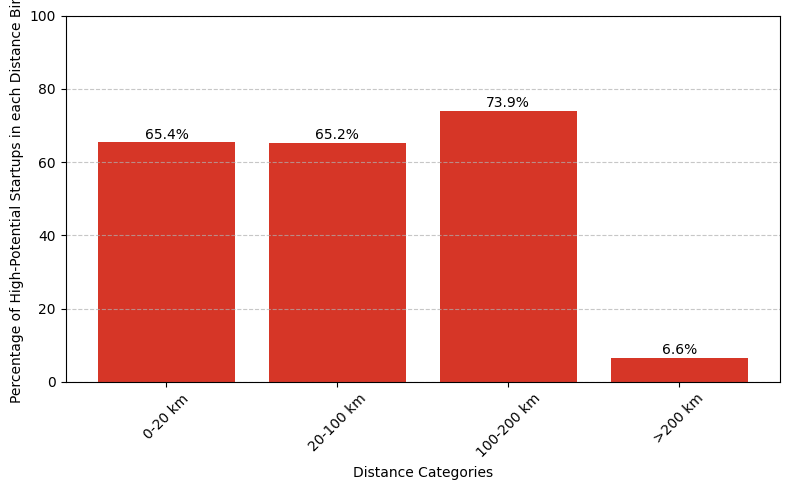

In [ ]:
# Ensure category mapping is applied correctly
category_mapping = {
    1: '0-20 km',
    2: '20-100 km',
    3: '100-200 km',
    4: '>200 km'
}

# Update category names in the dataset
oversampled['dist_bin_no'] = oversampled['dist_bin_no'].map(category_mapping)

category_order = ['0-20 km', '20-100 km', '100-200 km', '>200 km']
oversampled['dist_bin_no'] = pd.Categorical(oversampled['dist_bin_no'], categories=category_order, ordered=True)

# Calculate proportions
proportions = (
    oversampled.groupby('dist_bin_no')['high_potential']
    .mean()
    .reset_index()
    .rename(columns={'high_potential': 'proportion'})
)

# Sort categories if needed (ensure the order is consistent)
proportions = proportions.sort_values(by='dist_bin_no')

# Create Bar Chart
plt.figure(figsize=(8, 5))
bars = plt.bar(proportions['dist_bin_no'], proportions['proportion'] * 100, color='#d63627')
plt.xlabel('Distance Categories')
plt.ylabel('Percentage of High-Potential Startups in each Distance Bin')
plt.ylim(0, 100)  # Set y-axis limit to percentage range
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Annotate bars with percentages
for bar in bars:
    height = bar.get_height()
    if not pd.isna(height):  # Skip NaN values
        plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


<ipython-input-65-3b5e5f692dce>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  oversampled.groupby('funding_no')['high_potential']


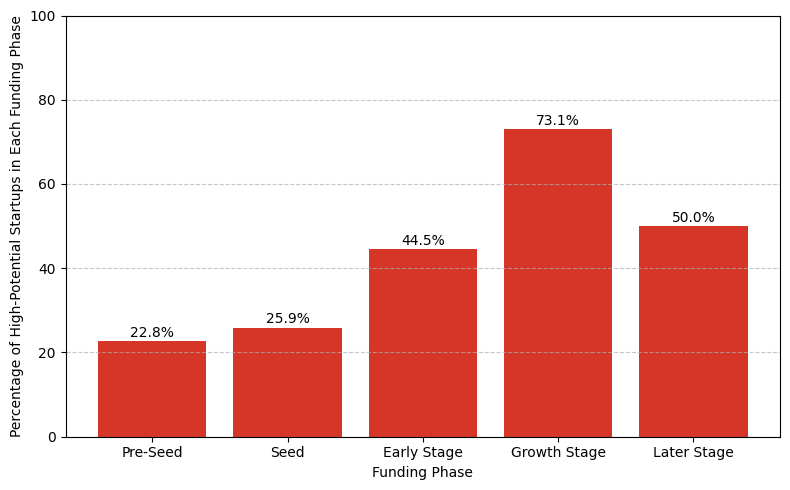

In [ ]:
# Ensure category mapping is applied correctly
category_mapping = {
    1: 'Pre-Seed',
    2: 'Seed',
    3: 'Early Stage',
    4: 'Growth Stage',
    5: 'Later Stage'
}
oversampled['funding_no'] = oversampled['funding_no'].map(category_mapping)

category_order = ['Pre-Seed', 'Seed', 'Early Stage', 'Growth Stage', 'Later Stage']
oversampled['funding_no'] = pd.Categorical(oversampled['funding_no'], categories=category_order, ordered=True)

# Calculate proportions
proportions = (
    oversampled.groupby('funding_no')['high_potential']
    .mean()
    .reset_index()
    .rename(columns={'high_potential': 'proportion'})
)

# Bar Chart
plt.figure(figsize=(8, 5))
bars = plt.bar(proportions['funding_no'], proportions['proportion'] * 100, color = '#d63627')
plt.xlabel('Funding Phase')
plt.ylabel('Percentage of High-Potential Startups in Each Funding Phase')
plt.ylim(0, 100)  # Set y-axis limit to percentage range
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate percentages
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
category_mapping = {
    1: 'Pre-Seed',
    2: 'Seed',
    3: 'Early Stage',
    4: 'Growth Stage',
    5: 'Later Stage'
}
oversampled['funding_no'] = oversampled['funding_no'].map(category_mapping)

category_order = ['Pre-Seed', 'Seed', 'Early Stage', 'Growth Stage', 'Later Stage']
oversampled['funding_no'] = pd.Categorical(oversampled['funding_no'], categories=category_order, ordered=True)

# Calculate proportions
proportions = (
    oversampled.groupby('funding_no')['high_potential']
    .mean()
    .reset_index()
    .rename(columns={'high_potential': 'proportion'})
)

# Bar Chart
plt.figure(figsize=(8, 5))
bars = plt.bar(proportions['funding_no'], proportions['proportion'] * 100, color = '#d63627')
plt.xlabel('Funding Phase')
plt.ylabel('Percentage of High-Potential Startups in Each Funding Phase')
plt.ylim(0, 100)  # Set y-axis limit to percentage range
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate percentages
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()
